# Use Categorial DQN to Play Pong-v4

TensorFlow version

In [1]:
%matplotlib inline

import copy
import logging
import itertools
import sys

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
from gym.wrappers.atari_preprocessing import AtariPreprocessing
from gym.wrappers.frame_stack import FrameStack
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import keras
from tensorflow import nn
from tensorflow import optimizers
from tensorflow import losses
from tensorflow.keras import layers
from tensorflow.keras import models

logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

Environment

In [2]:
env = FrameStack(AtariPreprocessing(gym.make('PongNoFrameskip-v4')),
        num_stack=4)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

00:27:33 [INFO] env: <AtariPreprocessing<TimeLimit<AtariEnv<PongNoFrameskip-v4>>>>
00:27:33 [INFO] action_space: Discrete(6)
00:27:33 [INFO] observation_space: Box(0, 255, (4, 84, 84), uint8)
00:27:33 [INFO] reward_range: (-inf, inf)
00:27:33 [INFO] metadata: {'render.modes': ['human', 'rgb_array']}
00:27:33 [INFO] num_stack: 4
00:27:33 [INFO] lz4_compress: False
00:27:33 [INFO] frames: deque([], maxlen=4)
00:27:33 [INFO] id: PongNoFrameskip-v4
00:27:33 [INFO] entry_point: gym.envs.atari:AtariEnv
00:27:33 [INFO] reward_threshold: None
00:27:33 [INFO] nondeterministic: False
00:27:33 [INFO] max_episode_steps: 400000
00:27:33 [INFO] _kwargs: {'game': 'pong', 'obs_type': 'image', 'frameskip': 1}
00:27:33 [INFO] _env_name: PongNoFrameskip


Agent

In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class C51Agent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99
        self.epsilon = 1. # exploration
        
        self.replayer = DQNReplayer(capacity=100000)

        self.atom_count = 51
        self.atom_min = -10.
        self.atom_max = 10.
        self.atom_difference = (self.atom_max - self.atom_min) \
                / (self.atom_count - 1)
        self.atom_tensor = tf.linspace(self.atom_min, self.atom_max,
                self.atom_count)

        self.evaluate_net = keras.Sequential([
                keras.layers.Permute((2, 3, 1), input_shape=(4, 84, 84)),
                layers.Conv2D(32, kernel_size=8, strides=4, activation=nn.relu),
                layers.Conv2D(64, kernel_size=4, strides=2, activation=nn.relu),
                layers.Conv2D(64, kernel_size=3, strides=1, activation=nn.relu),
                layers.Flatten(),
                layers.Dense(512, activation=nn.relu),
                layers.Dense(self.action_n * self.atom_count),
                layers.Reshape((self.action_n, self.atom_count)),
                layers.Softmax()])
        self.target_net = models.clone_model(self.evaluate_net)
        self.target_net.set_weights(self.evaluate_net.get_weights())
        self.optimizer = optimizers.Adam(0.0001)

    def reset(self, mode=None):
        self.mode = mode
        if mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        state_tensor = tf.convert_to_tensor(np.array(observation)[np.newaxis],
                dtype=tf.float32)
        prob_tensor = self.evaluate_net(state_tensor)
        q_component_tensor = prob_tensor * self.atom_tensor
        q_tensor = tf.reduce_mean(q_component_tensor, axis=2)
        action_tensor = tf.math.argmax(q_tensor, axis=1)
        actions = action_tensor.numpy()
        action = actions[0]
        if self.mode == 'train':
            if np.random.rand() < self.epsilon:
                action = np.random.randint(0, self.action_n)
            
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, act, next_state, reward, done, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, act, reward, next_state, done)
            if self.replayer.count >= 1024 and self.replayer.count % 10 == 0:
                self.learn()
        return action

    def close(self):
        pass

    def update_net(self, target_net, evaluate_net, learning_rate=0.005):
        average_weights = [(1. - learning_rate) * t + learning_rate * e for t, e
                in zip(target_net.get_weights(), evaluate_net.get_weights())]
        target_net.set_weights(average_weights)

    def learn(self):
        # replay
        batch_size = 32
        states, actions, rewards, next_states, dones = \
                self.replayer.sample(batch_size)
        state_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        reward_tensor = tf.convert_to_tensor(rewards[:, np.newaxis],
                dtype=tf.float32)
        done_tensor = tf.convert_to_tensor(dones[:, np.newaxis],
                dtype=tf.float32)
        next_state_tensor = tf.convert_to_tensor(next_states, dtype=tf.float32)

        # compute target
        next_prob_tensor = self.target_net(next_state_tensor)
        next_q_tensor = tf.reduce_sum(next_prob_tensor * self.atom_tensor,
                axis=2)
        next_action_tensor = tf.math.argmax(next_q_tensor, axis=1)
        next_actions = next_action_tensor.numpy()
        indices = [[idx, next_action] for idx, next_action in
                enumerate(next_actions)]
        next_dist_tensor = tf.gather_nd(next_prob_tensor, indices)
        next_dist_tensor = tf.reshape(next_dist_tensor,
                shape=(batch_size, 1, -1))

        # project
        target_tensor = reward_tensor + self.gamma * tf.reshape(
                self.atom_tensor, (1, -1)) * (1. - done_tensor) # broadcast
        clipped_target_tensor = tf.clip_by_value(target_tensor,
                self.atom_min, self.atom_max)
        projection_tensor = tf.clip_by_value(1. - tf.math.abs(
                clipped_target_tensor[:, np.newaxis, ...]
                - tf.reshape(self.atom_tensor, shape=(1, -1, 1)))
                / self.atom_difference, 0, 1)
        projected_tensor = tf.reduce_sum(projection_tensor * next_dist_tensor,
                axis=-1)

        with tf.GradientTape() as tape:
            all_q_prob_tensor = self.evaluate_net(state_tensor)
            indices = [[idx, action] for idx, action in enumerate(actions)]
            q_prob_tensor = tf.gather_nd(all_q_prob_tensor, indices)

            cross_entropy_tensor = -tf.reduce_sum(
                    tf.math.xlogy(projected_tensor, q_prob_tensor
                    + 1e-8))
            loss_tensor = tf.reduce_mean(cross_entropy_tensor)
        grads = tape.gradient(loss_tensor, self.evaluate_net.variables)
        self.optimizer.apply_gradients(
                zip(grads, self.evaluate_net.variables))

        self.update_net(self.target_net, self.evaluate_net)

        self.epsilon = max(self.epsilon - 1e-5, 0.05)



agent = C51Agent(env)

Train & Test

00:27:34 [INFO] ==== train ====
00:27:54 [DEBUG] train episode 0: reward = -20.00, steps = 1079
00:28:19 [DEBUG] train episode 1: reward = -21.00, steps = 790
00:28:50 [DEBUG] train episode 2: reward = -20.00, steps = 984
00:29:15 [DEBUG] train episode 3: reward = -21.00, steps = 819
00:29:42 [DEBUG] train episode 4: reward = -21.00, steps = 906
00:30:12 [DEBUG] train episode 5: reward = -19.00, steps = 984
00:30:50 [DEBUG] train episode 6: reward = -17.00, steps = 1268
00:31:22 [DEBUG] train episode 7: reward = -20.00, steps = 1041
00:31:51 [DEBUG] train episode 8: reward = -19.00, steps = 945
00:32:18 [DEBUG] train episode 9: reward = -21.00, steps = 869
00:32:42 [DEBUG] train episode 10: reward = -21.00, steps = 759
00:33:09 [DEBUG] train episode 11: reward = -20.00, steps = 889
00:33:37 [DEBUG] train episode 12: reward = -20.00, steps = 914
00:34:05 [DEBUG] train episode 13: reward = -20.00, steps = 942
00:34:35 [DEBUG] train episode 14: reward = -21.00, steps = 969
00:35:02 [DEBUG

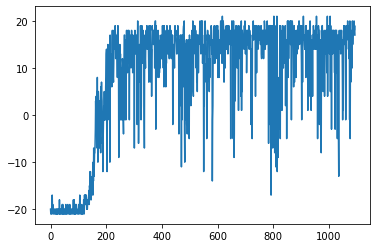

In [5]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env, agent, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > 18.:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))